In [1]:
# Importing necessary libraries and modules

import torch
import torch.nn as nn

print(torch.__version__)

2.9.1+cu128


In [2]:
# Device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!nvidia-smi

Mon Jan 26 22:22:35 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 590.48.01              Driver Version: 590.48.01      CUDA Version: 13.1     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    Off |   00000000:C4:00.0 Off |                  N/A |
| N/A   41C    P8              6W /   55W |      14MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Get Data

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory already exists... skipping download")
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get(
        "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
    )
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak and sushi data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists... skipping download
Unzipping pizza, steak and sushi data...


In [5]:
import os

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f" There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}',")

walk_through_dir(image_path)

 There are 2 directories and 0 images in 'data/pizza_steak_sushi',
 There are 3 directories and 0 images in 'data/pizza_steak_sushi/train',
 There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak',
 There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi',
 There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza',
 There are 3 directories and 0 images in 'data/pizza_steak_sushi/test',
 There are 1 directories and 19 images in 'data/pizza_steak_sushi/test/steak',
 There are 0 directories and 1 images in 'data/pizza_steak_sushi/test/steak/.ipynb_checkpoints',
 There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi',
 There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza',


In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Image path: data/pizza_steak_sushi/train/sushi/377047.jpg
Image class: sushi
Image height: 512
Image width: 382


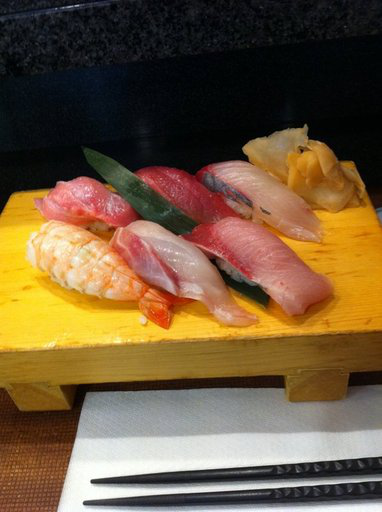

In [7]:
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

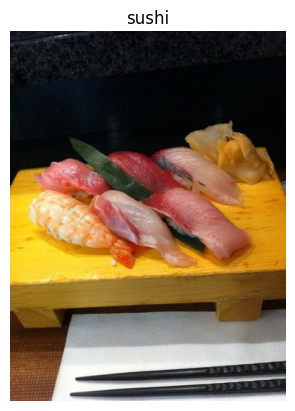

In [8]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.imshow(img_as_array)
plt.title(image_class)
plt.axis(False)
plt.show()

# Data Transformation

In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [10]:
data_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
])

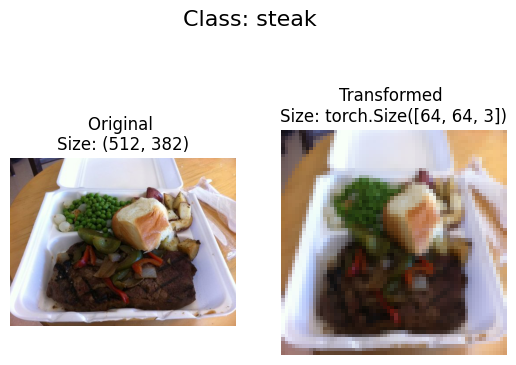

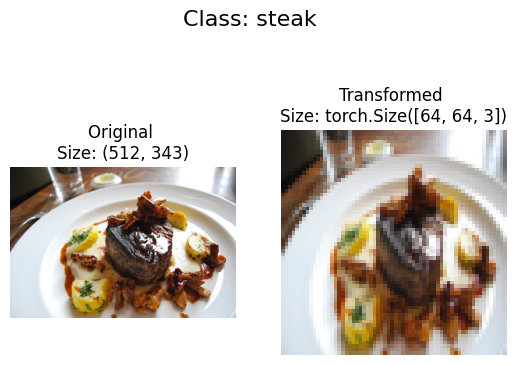

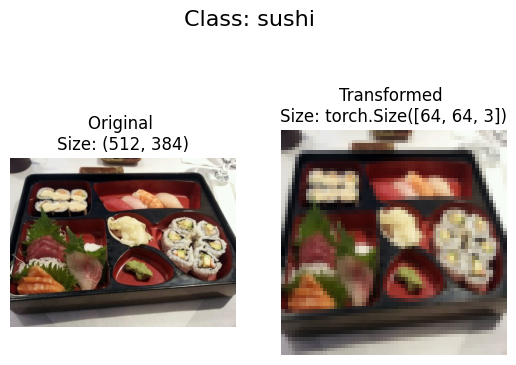

In [11]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.
 
    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

# Making data

In [12]:
train_data = datasets.ImageFolder(
    root = train_dir,
    transform = data_transform
)

test_data = datasets.ImageFolder(
    root = test_dir,
    transform  = data_transform
)

len(train_data), len(test_data)
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

# Data Loading 

In [13]:
train_dataloader = DataLoader(
    train_data,
    batch_size=32,
    shuffle = True
)

test_dataloader = DataLoader(
    test_data,
    batch_size=32,
    shuffle = False
)

len(train_dataloader), len(test_dataloader)   

(8, 3)

In [14]:
print(train_data.classes)
print(train_data.class_to_idx)

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}
